In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [5]:
r_path = Path(ROOT_DIR, 'results', 'r')
rpg_path = Path(ROOT_DIR, 'results', 'rpg')
rsg_path = Path(ROOT_DIR, 'results', 'rsg')

split_by = ['buffer_size', 'step_size', 'algo']

r_color = 'black'
rsg_color = 'darkorange'
rpg_color = 'forestgreen'


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [27]:
r_infos = [load_info(f) for f in r_path.iterdir()]
rpg_infos = [load_info(f) for f in rpg_path.iterdir()]

In [52]:
idx = 45
info = rpg_infos[idx]
args = info['args'].item()
(info['episode_reward'].max() == info['episode_reward']).sum()

10

In [6]:
def process_dir(dir_path, split_by=None, discount=0.99):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        # We only consider prefilled here
        if args['p_prefilled'] != 0.:
            continue
        
        result = info['episode_reward'] * (discount ** info['episode_length'])

        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            all_results[split_by_tuple][hparams].append((info['episode_length'], result))
            
        else:
            all_results.append((info['episode_length'], result))
            
#     if split_by is not None:
#         for k, v in all_results.items():
#             for k1, v1 in v.items():
#                 all_results[k][k1] = np.array(all_results[k][k1])
#         data = all_results
#     else:
#         data = np.array(all_results)

    
    return all_results


In [29]:
discount = 1.0
r_data = process_dir(r_path, split_by=split_by, discount=discount)
rpg_data = process_dir(rpg_path, split_by=split_by, discount=discount)
rsg_data = process_dir(rsg_path, split_by=split_by, discount=discount)

In [14]:
r_data

{('buffer_size',
  'step_size',
  'algo'): {(25000,
   2e-14,
   'sarsa'): [(array([   5,    8,    6, ...,    4,    3, 1000]),
    array([9.5099005 , 9.22744694, 9.41480149, ..., 9.6059601 , 9.70299   ,
           0.        ])), (array([ 930, 1000, 1000, ..., 1000,  829, 1000]),
    array([ 0.        , -0.00043171,  0.        , ...,  0.        ,
            0.00240756,  0.        ])), (array([ 605,   63, 1000, ..., 1000, 1000, 1000]),
    array([0.0457428 , 5.30905543, 0.        , ..., 0.        , 0.        ,
           0.        ])), (array([1000, 1000, 1000, ...,  596, 1000, 1000]),
    array([ 0.        , -0.00086342,  0.00043171, ...,  0.02503664,
            0.        ,  0.        ])), (array([1000, 1000, 1000, ..., 1000, 1000, 1000]),
    array([ 0.        , -0.13037717, -0.00043171, ..., -0.00647569,
           -0.00388541, -0.0518055 ])), (array([ 153, 1000, 1000, ..., 1000,  444, 1000]),
    array([ 2.14874448e+00,  0.00000000e+00, -8.63424948e-04, ...,
            0.00000000e

In [8]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data[tuple(split_by)].items():
        final_max = np.mean([np.mean(dis_rew[-100:]) for length, dis_rew in all_dis_rew])
        hparam_results.append((args, final_max))
    return hparam_results


In [9]:
eps_max_over = 100
r_max_over = get_eps_max_over(r_data, eps_max_over)
rpg_max_over = get_eps_max_over(rpg_data, eps_max_over)
rsg_max_over = get_eps_max_over(rsg_data, eps_max_over)

In [10]:
# Get the best hyperparams based on the final 100 episodes
r_best = sorted(r_max_over, key=lambda x : x[1], reverse=True)[0]
rpg_best = sorted(rpg_max_over, key=lambda x : x[1], reverse=True)[0]
rsg_best = sorted(rsg_max_over, key=lambda x : x[1], reverse=True)[0]

r_best, rpg_best, rsg_best

(((25000, 2e-12, 'esarsa'), 1.5861785031433806),
 ((25000, 2e-12, 'esarsa'), 1.5889691070883702),
 ((25000, 2e-14, 'sarsa'), 1.4725891071021895))

In [11]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


def map_dis_rew_to_steps(data, w=1000):
    all_seeds = []
    for lengths, dis_rews in data:
        current_seed = []
        for length, dis_rew in zip(lengths, dis_rews):
            current_seed.append(np.zeros(length) + dis_rew)
        all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
    return np.array(all_seeds)

In [12]:
trunc = int(5e5)

r_best_data = r_data[tuple(split_by)][r_best[0]]
rpg_best_data = rpg_data[tuple(split_by)][rpg_best[0]]
rsg_best_data = rsg_data[tuple(split_by)][rsg_best[0]]

mapped_r = map_dis_rew_to_steps(r_best_data)
mapped_rpg = map_dis_rew_to_steps(rpg_best_data)
mapped_rsg = map_dis_rew_to_steps(rsg_best_data)

In [117]:
all_data = [
    ('Normal obs', mapped_r, r_color),
    ('PF obs', mapped_rpg, rpg_color),
    ('Ground-truth obs', mapped_rsg, rsg_color)
]

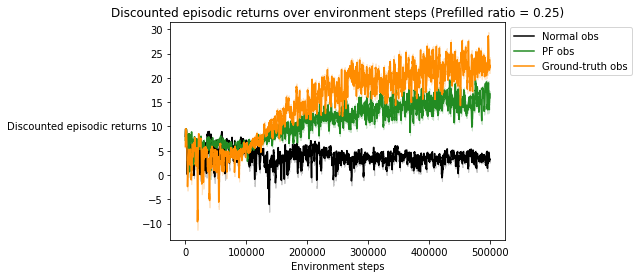

In [121]:
x = np.arange(mapped_r.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.25)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
